# Loading Modules

In [1]:
import sys
sys.path.append('../../../Julia Gachot 2019/POLO/dev')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from stn import STN_128x128

Default lg shape= 32 32


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [3]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Log Gabor parameters

In [4]:
width = 32
n_levels = 3 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
base_levels = 2
#base_levels = 1.61803

n_color = 1
r_min = width / 4 
r_max = width / 2 
n_sublevel = n_eccentricity = 2
n_azimuth = 16
n_theta = 8
n_phase = 1

In [5]:
gauss = False
do_mask = False
color = False

In [6]:
pe = {'N_X': width, 'N_Y': width, 'do_mask': do_mask, 'base_levels':
          base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)

print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)


Text(0.5, 1.0, 'K coefficients')

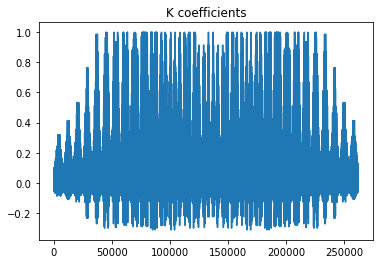

In [7]:
K = get_K(width=width,
          n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
          n_theta = n_theta,
          n_phase = n_phase, 
          r_min = r_min, 
          r_max = r_max, 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg)

plt.plot(K.flatten())
plt.title('K coefficients')

### Honeycomb space coverage tests


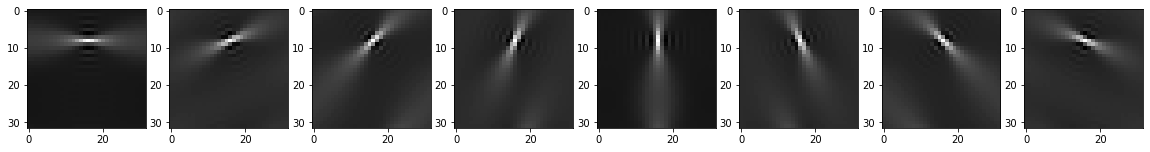

In [8]:
plt.figure(figsize=(20,3))
for i_theta in range(n_theta):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[0, n_azimuth//2, i_theta, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(1,n_theta,i_theta+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

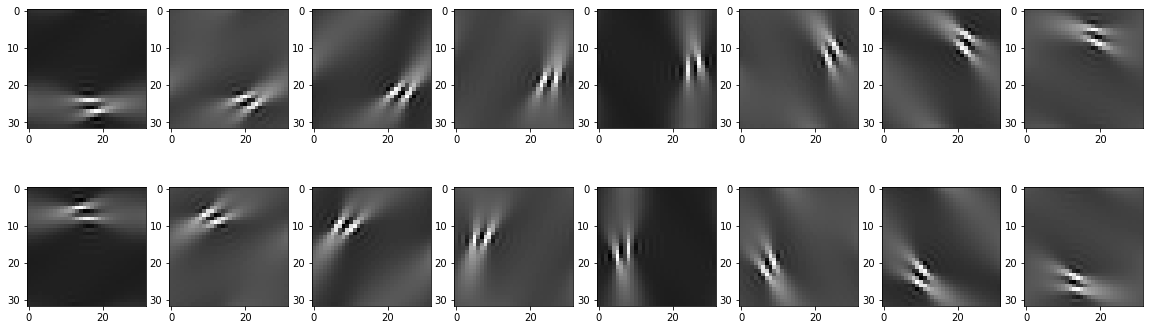

In [9]:
plt.figure(figsize=(20,6))
for i_az in range(n_azimuth):
    coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
    coefs[:, i_az, 0, 0] = 1
    img_dis = torch.tensordot(K, coefs, dims=4)
    plt.subplot(2,n_azimuth//2,i_az+1)
    plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

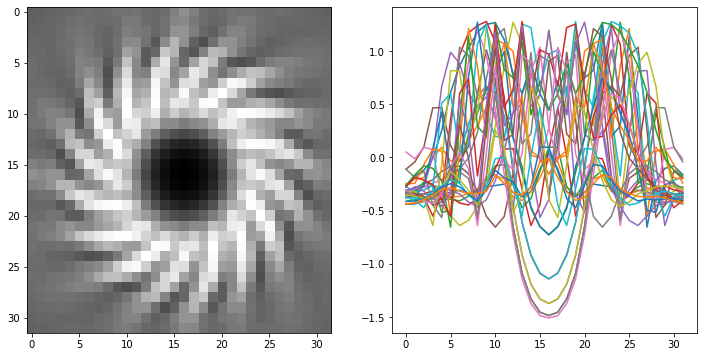

In [10]:
plt.figure(figsize=(12,6))
coefs = torch.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, 2:3, 0] = torch.ones((n_sublevel, n_azimuth, 1))
img_dis = torch.tensordot(K, coefs, dims=4)
plt.subplot(1,2,1)
plt.imshow(img_dis.numpy(), cmap='gray', aspect='auto')
plt.subplot(1,2,2)
_=plt.plot(img_dis.numpy())

## inverse Log Gabor

In [11]:
K.shape

torch.Size([32, 32, 2, 16, 8, 1])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])


Text(0.5, 1.0, 'K_inv coefficients')

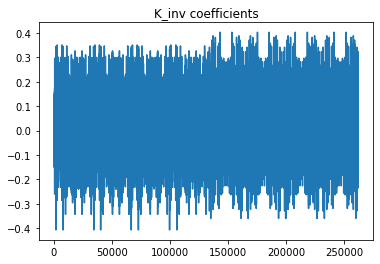

In [12]:
K_inv = get_K_inv(K, 
                  width=width, 
                  n_sublevel = n_sublevel, 
                  n_azimuth = n_azimuth, 
                  n_theta = n_theta, 
                  n_phase = n_phase)
plt.plot(K_inv.flatten())
plt.title('K_inv coefficients')

log_gabor_rosace shape:  torch.Size([1, 3, 2, 16, 8, 1])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
img_crop_rosace shape: torch.Size([1, 3, 32, 32])


<Figure size 432x288 with 0 Axes>

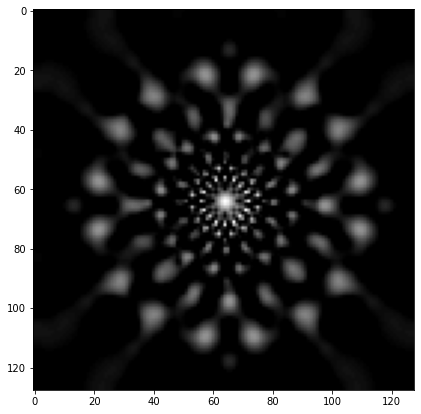

In [13]:
log_gabor_rosace = 100 * torch.ones(1, n_levels, n_eccentricity, n_azimuth, n_theta, n_phase)
plt.figure()
print('log_gabor_rosace shape: ', log_gabor_rosace.shape)

img_crop_rosace=inverse_gabor(log_gabor_rosace, K_inv)
print('img_crop_rosace shape:', img_crop_rosace.shape)
#img_crop_rosace[:,-1,...] = 128 
full_rosace = inverse_pyramid(img_crop_rosace, color=color, gauss=gauss, n_levels=n_levels, base_levels=base_levels)
full_rosace = full_rosace.detach().permute(0,2,3,1).numpy().clip(0,255).astype('uint8')
#ax = tensor_image_cmp(full_img_rec, full_img_rec_rec)
plt.figure(figsize=(7,7))
plt.imshow(full_rosace.squeeze(), cmap='gray')

In [14]:
2*16*8, 32*32

(256, 1024)

In [15]:
img_crop_rosace.shape

torch.Size([1, 3, 32, 32])

### Adapted cropped pyramid (squeezed tensor)

In [16]:
class CroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
    
    def __call__(self, img):
        img_crop, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels,
                                               color_mode=self.color_mode)
        return img_crop
        

### LogGaborTransform

In [17]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, img_crop):
        log_gabor_coeffs = log_gabor_transform(img_crop.unsqueeze(1), K, color=self.color)
        
        return log_gabor_coeffs

In [18]:
class LogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        log_gabor_coeffs = log_gabor_coeffs.permute(1, 4, 5, 0, 2, 3).contiguous()
        log_gabor_coeffs = log_gabor_coeffs.view(self.n_color*self.n_theta*self.n_phase, 
                                                 self.n_levels * self.n_eccentricity, 
                                                 self.n_azimuth)
        
        return log_gabor_coeffs

### Inverse transformations (for display only)

In [19]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [20]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        img_crop=inverse_gabor(log_gabor_coeffs[:, :, 0, ...].detach(), K_inv)
        print('img_crop.shape:', img_crop.shape)
        
        return img_crop

In [21]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
    
    def __call__(self, img_crop):
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = 128,
                                       N_Y = 128,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels)
                                       #color_mode=self.color_mode)
        return full_img_rec

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [22]:
args.offset_max = 40 #like in the paper

In [23]:
args.offset_std = 40
args.contrast = 0.7

In [24]:
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args, radius = 0),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf, flexible=True),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor(),
    CroppedPyramid(width, 
                   base_levels, 
                   n_levels=n_levels),
    LogGaborTransform(color=color),
    LogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color)
])

In [25]:
train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [26]:
data_big, label_big = next(iter(train_loader))

In [27]:
data_big.shape

torch.Size([100, 8, 6, 16])

### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [28]:
inverse_transform = transforms.Compose([
    LogGaborInvReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
    LogGaborInvTransform(K_inv=K_inv, color=color),
    InvCroppedPyramid(base_levels, n_levels=n_levels),
])

log_gabor_coeffs.shape: torch.Size([100, 8, 6, 16])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
img_crop.shape: torch.Size([100, 3, 32, 32])


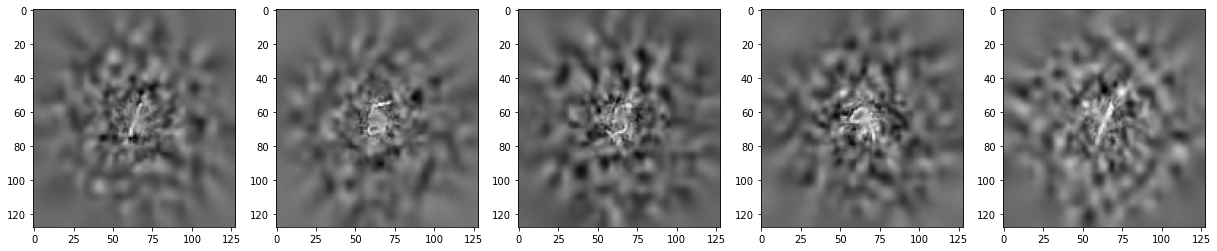

In [29]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 4))
full_img_rec = inverse_transform(data_big)
for i_ax, ax in enumerate(axs):
    ax.imshow(full_img_rec[i_ax,...].detach().numpy().squeeze(), aspect='auto', cmap='gray')

# Creating a STN_128x128 model with log-polar entry

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STN_128x128().to(device)

In [44]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        data.double()

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            data.double()
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

# Training parameters of the What/Where model

In [45]:
eccentricities = np.linspace(args.offset_max, 0, 9, endpoint=False)[::-1]
eccentricities

array([ 4.44444444,  8.88888889, 13.33333333, 17.77777778, 22.22222222,
       26.66666667, 31.11111111, 35.55555556, 40.        ])

In [46]:
contrasts = (0.7, 0.5, 0.3)

# Training on contrast 0.7

In [47]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, last_epoch=-1, verbose=True)

In [48]:
acc = []
for offset in eccentricities[:2]:

    args.offset_std = offset

    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf,
                        flexible=True), 
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])
    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (offset))
    args.epochs = 10

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        curr_acc = test(test_loader)
        acc.append(curr_acc)
        scheduler.step()

Training on eccentricity=4.444444444444443


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.DoubleTensor) should be the same